## Example Linear Model in Python<br>
<br>

**0) Loading Libraries**<br>
<br>

In [ ]:
#standard libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
#for QQ plot
import pylab 
import scipy.stats as stats

In [ ]:
#OLS: (ordinary least squares), the function for running the linear regression
#sm: statsmodels for determining p-values via ANOVA
import statsmodels.api as sm
from statsmodels.formula.api import ols

In [ ]:
#for scaling and normalizing the data
from sklearn.preprocessing import MinMaxScaler

<br>

**1) Loading and Extracting the Data**<br>
<br>

The molecule data set contains the column *"toxicity_score"* as dependent, numerical (not categorical) variable.

In [ ]:
Train  = pd.read_csv("molecular_train_gbc.csv")
Test   = pd.read_csv("molecular_test_gbc.csv")
print(Test.head())

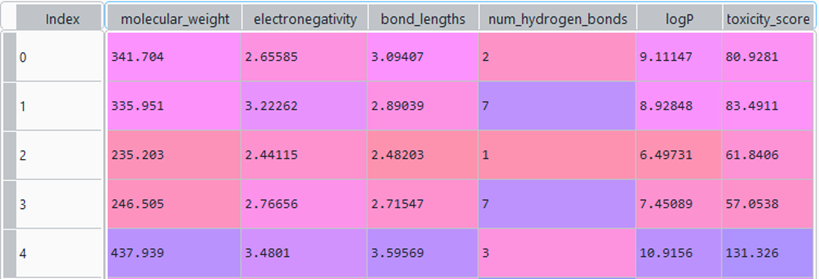

<br>

**2) Plotting the Data**<br>
<br>

In [ ]:
out = sns.pairplot(Train, kind="kde", \
                   plot_kws={'color':[176/255,224/255,230/255]}, \
                   diag_kws={'color':'black'})
out.map_offdiag(plt.scatter, color = 'black')
plt.show()

<br>

**3) Scaling the Data**<br>
<br>

In order to avoid that the model gets optimized for quantities that appear to have large values because of an arbritaryly choosen unit system, the data has to be normalized and scaled to the same dynamical range.

In [ ]:
scaler    = MinMaxScaler(feature_range = (0, 1)) #mean  = 0 and std = 1
All       = pd.concat((Train, Test), axis = 0)
(rows, _) = Train.shape
AllS      = scaler.fit_transform(All)

#scaling returns an array, but we need a dataframe for the fit routine
TrainS = pd.DataFrame(AllS[:rows,:], columns = Train.columns)
TestS  = pd.DataFrame(AllS[rows:,:], columns = Train.columns)

<br>

**4) Performing the Fit**<br>
<br>

In [ ]:
equation = 'toxicity_score ~ ' + '+'.join(Train.columns[:-1])
print(equation)

Where the toxicity score correponds to $y$ (dependent variable) and molecular weight, electronegativity, bond lengths, number of hydrogen bonds and logP correpond to the $x_n$ in<br>
<br>
$y = \beta_0 + \Sigma_{n = 1}^{N} \beta_n\,x_n + \epsilon$
<br>

Fitting the model using *OLS*:

In [ ]:
#OLS (ordinary least squares)
my_model = ols(equation, data = TrainS).fit()
my_model.summary()

The fit is significant, because the p-value Prob (F-statistic) for the constant model equals 3.34e-266, i.e. equals zero.<br>
The degree of freedom is more than an order of magintude larger than the number of regressors as it should be.<br>
Molecular weight, electronegativity and intercept are significant (p-values are below 0.01). However, these p-values are derived by comparing the fit residuals of the **complete model** to the fit residuals of the model without the single corresponding regressor using a t-test (see t-value in table above). This might lead to an underestimation of the influence of the regressor on the model, if the number of regressors is large.<br>  
Running an **ANOVA** (**AN**alysis **O**f **VA**riance) gives a better estimate of the p-values. There are different ways how to apply an **ANOVA**. We want to choose type *one* which works as follows:
We remove one of the factors, perform a fit and save the fit residuals. Next step we include the factor we previously removed, but now remove another factor, perform the fit and save the fit residuals. The procedure is repeated with all *N* factors. Finally, we obtain *N* different sets of fit residuals and run an **ANOVA**.

In [ ]:
table    = sm.stats.anova_lm(my_model, typ = 1)
print(table)

<br>

**5) Evaluating the Fit**<br>
<br>

Using ANOVA or the t-test for calculating the p-values of the regressors requires the fit residuals to be approximatly normally distributed. Therefore, we create a histogram and a Q-Q plot of the fit resiudals. 

In [ ]:
residuals = my_model.resid

In [ ]:
plt.hist(residuals, color = 'w', edgecolor = 'black')
plt.title('fit residuals')
plt.ylabel('#')
plt.xlabel('value')
plt.show()

In [ ]:
stats.probplot(residuals, dist = "norm", plot = pylab)
pylab.show()

It all looks great and the stats make sense. Thus we can apply the model now:

In [ ]:
Ypred = my_model.predict(TestS)

In [ ]:
higher = np.max([Ypred, TestS.toxicity_score])
lower  = np.min([Ypred, TestS.toxicity_score])

plt.plot([lower, higher], [lower, higher], c = [0, 0, 0, 0.2], linewidth = 4)
plt.scatter(TestS.toxicity_score, Ypred, marker = '.', c = 'k')
plt.ylabel('prediction')
plt.xlabel('toxicity score')
plt.show()

Again, the plot looks great. There are no systematic deviations. Finally, let us calculate the mean deviation between prediction and actual value of the toxicity score:

In [ ]:
mean_dev = np.sum(abs(TestS.toxicity_score - Ypred))/len(Ypred)
print(mean_dev)

##### The result is 5%. A good fit